In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import theano
import theano.tensor as tt 
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


cpu


Generate Data

In [2]:
def encode_counts(counts):
    # turn counts of position into word-style encoding
    # https://laptrinhx.com/topic-modeling-with-pymc3-398251916/
    # A[C>A]A, A[C>G]A, A[C>T]A, A[C>A]C... T[T>G]T
    
    x32 = np.tile([np.arange(16), np.arange(16, 32)], 3).reshape(-1)
    y6 = np.repeat([0,1,2,0,2,1], 16)
    
    S, C = counts.shape
    sel = [np.repeat(range(C), counts[i].astype(int)) for i in range(S)]

    X = [x32[s] for s in sel]
    Y = [y6[s] for s in sel]
    
    return X, Y

In [3]:
C = 32
M = 3
J = 2
K = 2
N = np.array([1000] * 10)
S = len(N)

# Hyper-parameter for priors
alpha = np.ones(C) * 0.05
#alpha[0] = 1
psi = np.ones(J)
gamma = np.ones(K) * 0.1
#gamma = np.array([5,0.1,0.1,0.1]) * 0.1
beta = np.ones((K,4)) * 0.1
#beta = np.repeat(np.array([[1, 0.1, 1, 5]]), K, axis=0)

In [4]:
phi_gen = pm.Dirichlet.dist(a=alpha, shape=(C)).random(size = J)
theta_gen = pm.Dirichlet.dist(a=psi).random(size = S)
A_gen = pm.Dirichlet.dist(a=gamma, shape=(J, K)).random(size = S)
# ACGT
# 0123
eta_gen = np.vstack([[pm.Dirichlet.dist(a=beta[:,[0,2,3]]).random(size=1)] * 16, 
                     [pm.Dirichlet.dist(a=beta[:,[0,1,2]]).random(size=1)] * 16]).squeeze()
#eta_gen = np.vstack([pm.Dirichlet.dist(a=beta[:,[0,2,3]]).random(size=C//2), 
#                     pm.Dirichlet.dist(a=beta[:,[0,1,2]]).random(size=C//2)])

In [5]:
W=(theta_gen@phi_gen).T
Q=np.einsum('sj,sjk->sk', theta_gen, A_gen)@eta_gen
B=np.einsum('cs,csm->scm',W,Q).reshape(S, -1)
data = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, B)])
X_encoded, Y_encoded = encode_counts(data)

Preview simulated signatures

In [6]:
# requires reorder for Y>A Y>G Y>Y
yy_to_mutsig = np.array([ 0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45,
                         1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 
                         2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 
                         48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 
                         49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 
                         50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95])

yy = np.vstack([np.outer(phi_gen[j,c], eta_gen[c, k, :]) \
                for j in range(J) for k in range(K) for c in range(C)]).reshape(J, K, -1)

mutsig = np.array([yy[j][k][yy_to_mutsig] for j in range(J) for k in range(K)]).reshape(J, K, -1)

In [7]:
mut96 = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 
         'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 
         'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 
         'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 
         'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 
         'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 
         'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 
         'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 
         'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 
         'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 
         'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 
         'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']


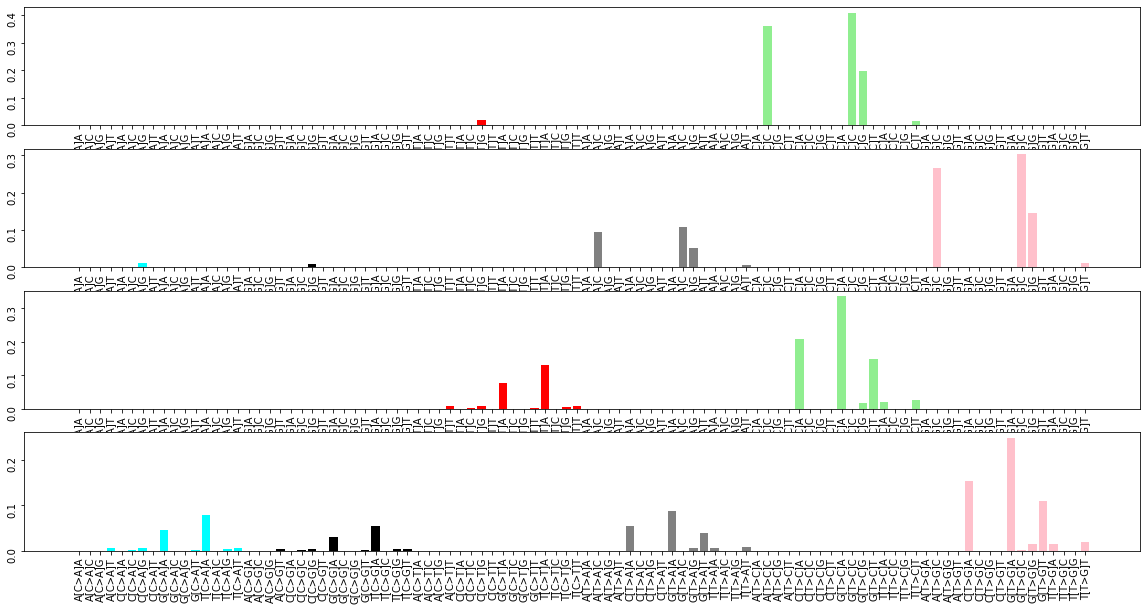

In [8]:
plt.figure(figsize=(20,10))
i=0
for j in range(J):
    for k in range(K):
        i += 1
        plt.subplot(J*K,1,i)
        plt.bar(mut96, mutsig[j,k], color=np.repeat(['cyan', 'black', 'red', 'grey', 'lightgreen', 'pink'], 16))
        #plt.tick_params(bottom=False,labelbottom=False
        plt.tick_params(labelsize=10, rotation=90)

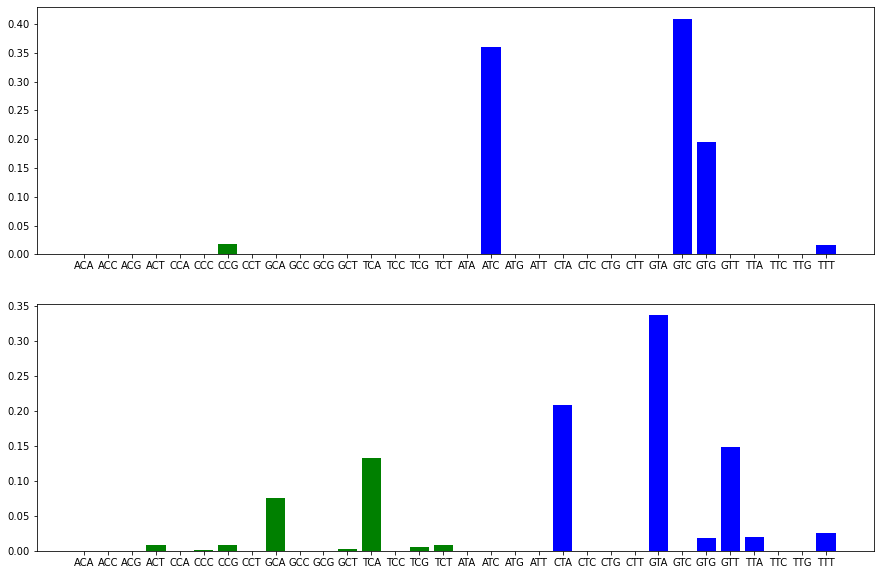

In [9]:
plt.figure(figsize=(15,10))
for j in range(J):
    plt.subplot(J,1,j+1)
    plt.bar(['ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT', 
             'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT', 
             'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT', 
             'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT'],
            phi_gen[j], color = np.repeat(['green', 'blue'], 16))
#plt.tick_params(labelsize=12, rotation=45)

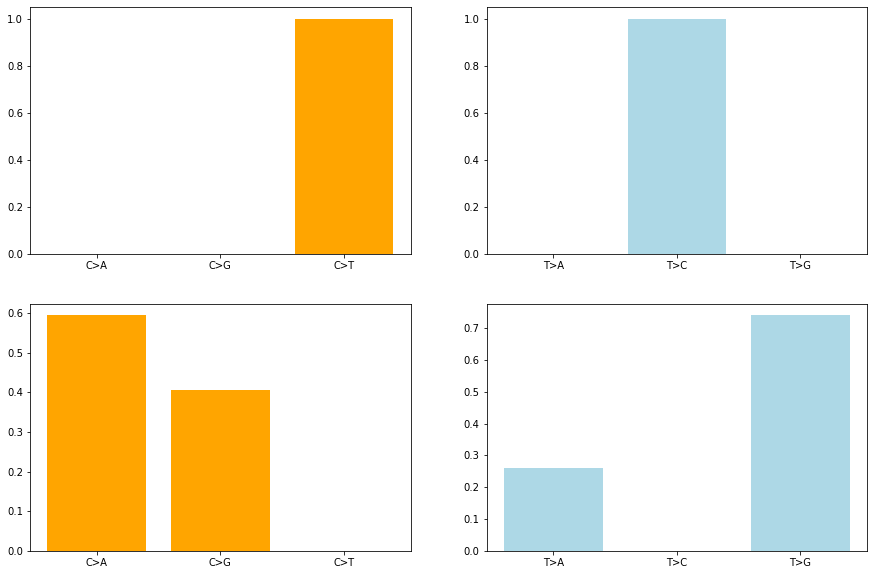

In [10]:
plt.figure(figsize=(15,10))
i=-1
for k in range(K):
    i+=2
    plt.subplot(K,2,i)
    plt.bar(['C>A','C>G','C>T'], eta_gen[0,k], color = 'orange')
    plt.subplot(K,2,i+1)
    plt.bar(['T>A','T>C','T>G'], eta_gen[16,k], color = 'lightblue')

## Full two step model

In [11]:
with pm.Model() as full_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))

    
    for s in range(S):
        # draw damage context signature
        z = pm.Categorical(f"z_{s}", p=theta[s], shape=N[s])
        # draw mutation damage context
        x = pm.Categorical(f"x_{s}", p=phi[z], shape=N[s], observed=X_encoded[s])
        # draw mutation signature
        v = pm.Categorical(f"v_{s}", p=A[s,z], shape=N[s])
        # draw mutation
        y = pm.Categorical(f"y_{s}", p=eta[x,v], shape=N[s], observed=Y_encoded[s])

Fit the model. 
The full model would take > 46 hours, to fit 10 samples. Not performed in this notebook. 

```
with full_model:    
    full_trace = pm.sample(1000, return_inferencedata=True)
```

Sanity check the result

```
az.plot_posterior(full_trace, var_names=['theta']);
```

```
plt.figure(figsize=(20,5))
for j in range(J):
    plt.subplot(J,1,j+1)
    for c in range(C):
        sns.distplot(full_trace.posterior['phi'][:, :, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')
```

```
with full_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))
```

```
with full_model:
    ppc = pm.sample_posterior_predictive(
        full_trace, random_seed=5
    )
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=full_model));
```

## 'collapsed' two step LDA

In [12]:
with pm.Model() as collapsed_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))

    B = pm.Deterministic("B", (pm.math.matrix_dot(theta, phi)[:,:,None] * \
                               pm.math.matrix_dot(tt.batched_dot(theta,A),eta)).reshape((S, -1)))    
                               
    # mutation counts
    for s in range(S):
        pm.Multinomial(f'sample_{s}', n = N[s], p = B , observed=data[s])

Fit the model with MCMC

In [13]:
with collapsed_model:
    collapsed_trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etaT, etaC, A, theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1320 seconds.
There were 645 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 382 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective s

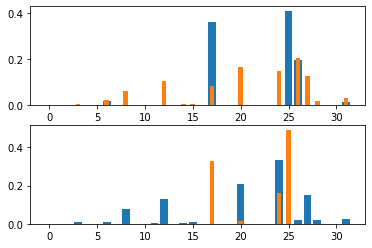

In [14]:
for j in range(J):
    plt.subplot(J,1,j+1)
    plt.bar(np.arange(0,32), phi_gen[j])
    plt.bar(np.arange(0,32), collapsed_trace.posterior.phi[0][0][j], width=0.5)

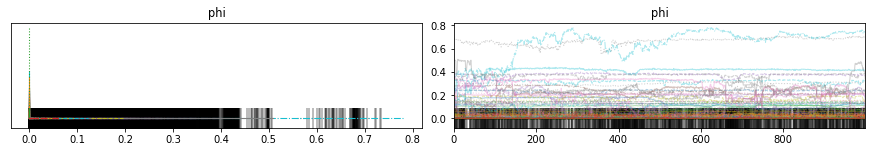

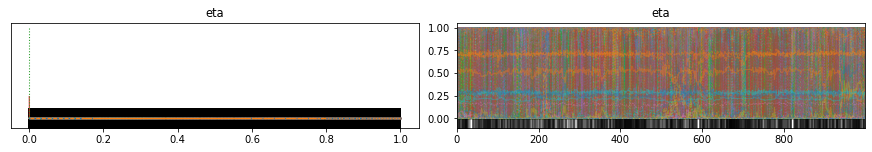

In [15]:
with collapsed_model:
    az.plot_trace(collapsed_trace, var_names='phi')
    az.plot_trace(collapsed_trace, var_names='eta')

In [16]:
a = pm.model_to_graphviz(collapsed_model)
a.save('twostep_N0')

'twostep_N0'

In [17]:
%%bash
~/miniconda3/envs/pymc3/bin/dot -Kdot -Tpng -O twostep_N0

![](twostep_N0.png)

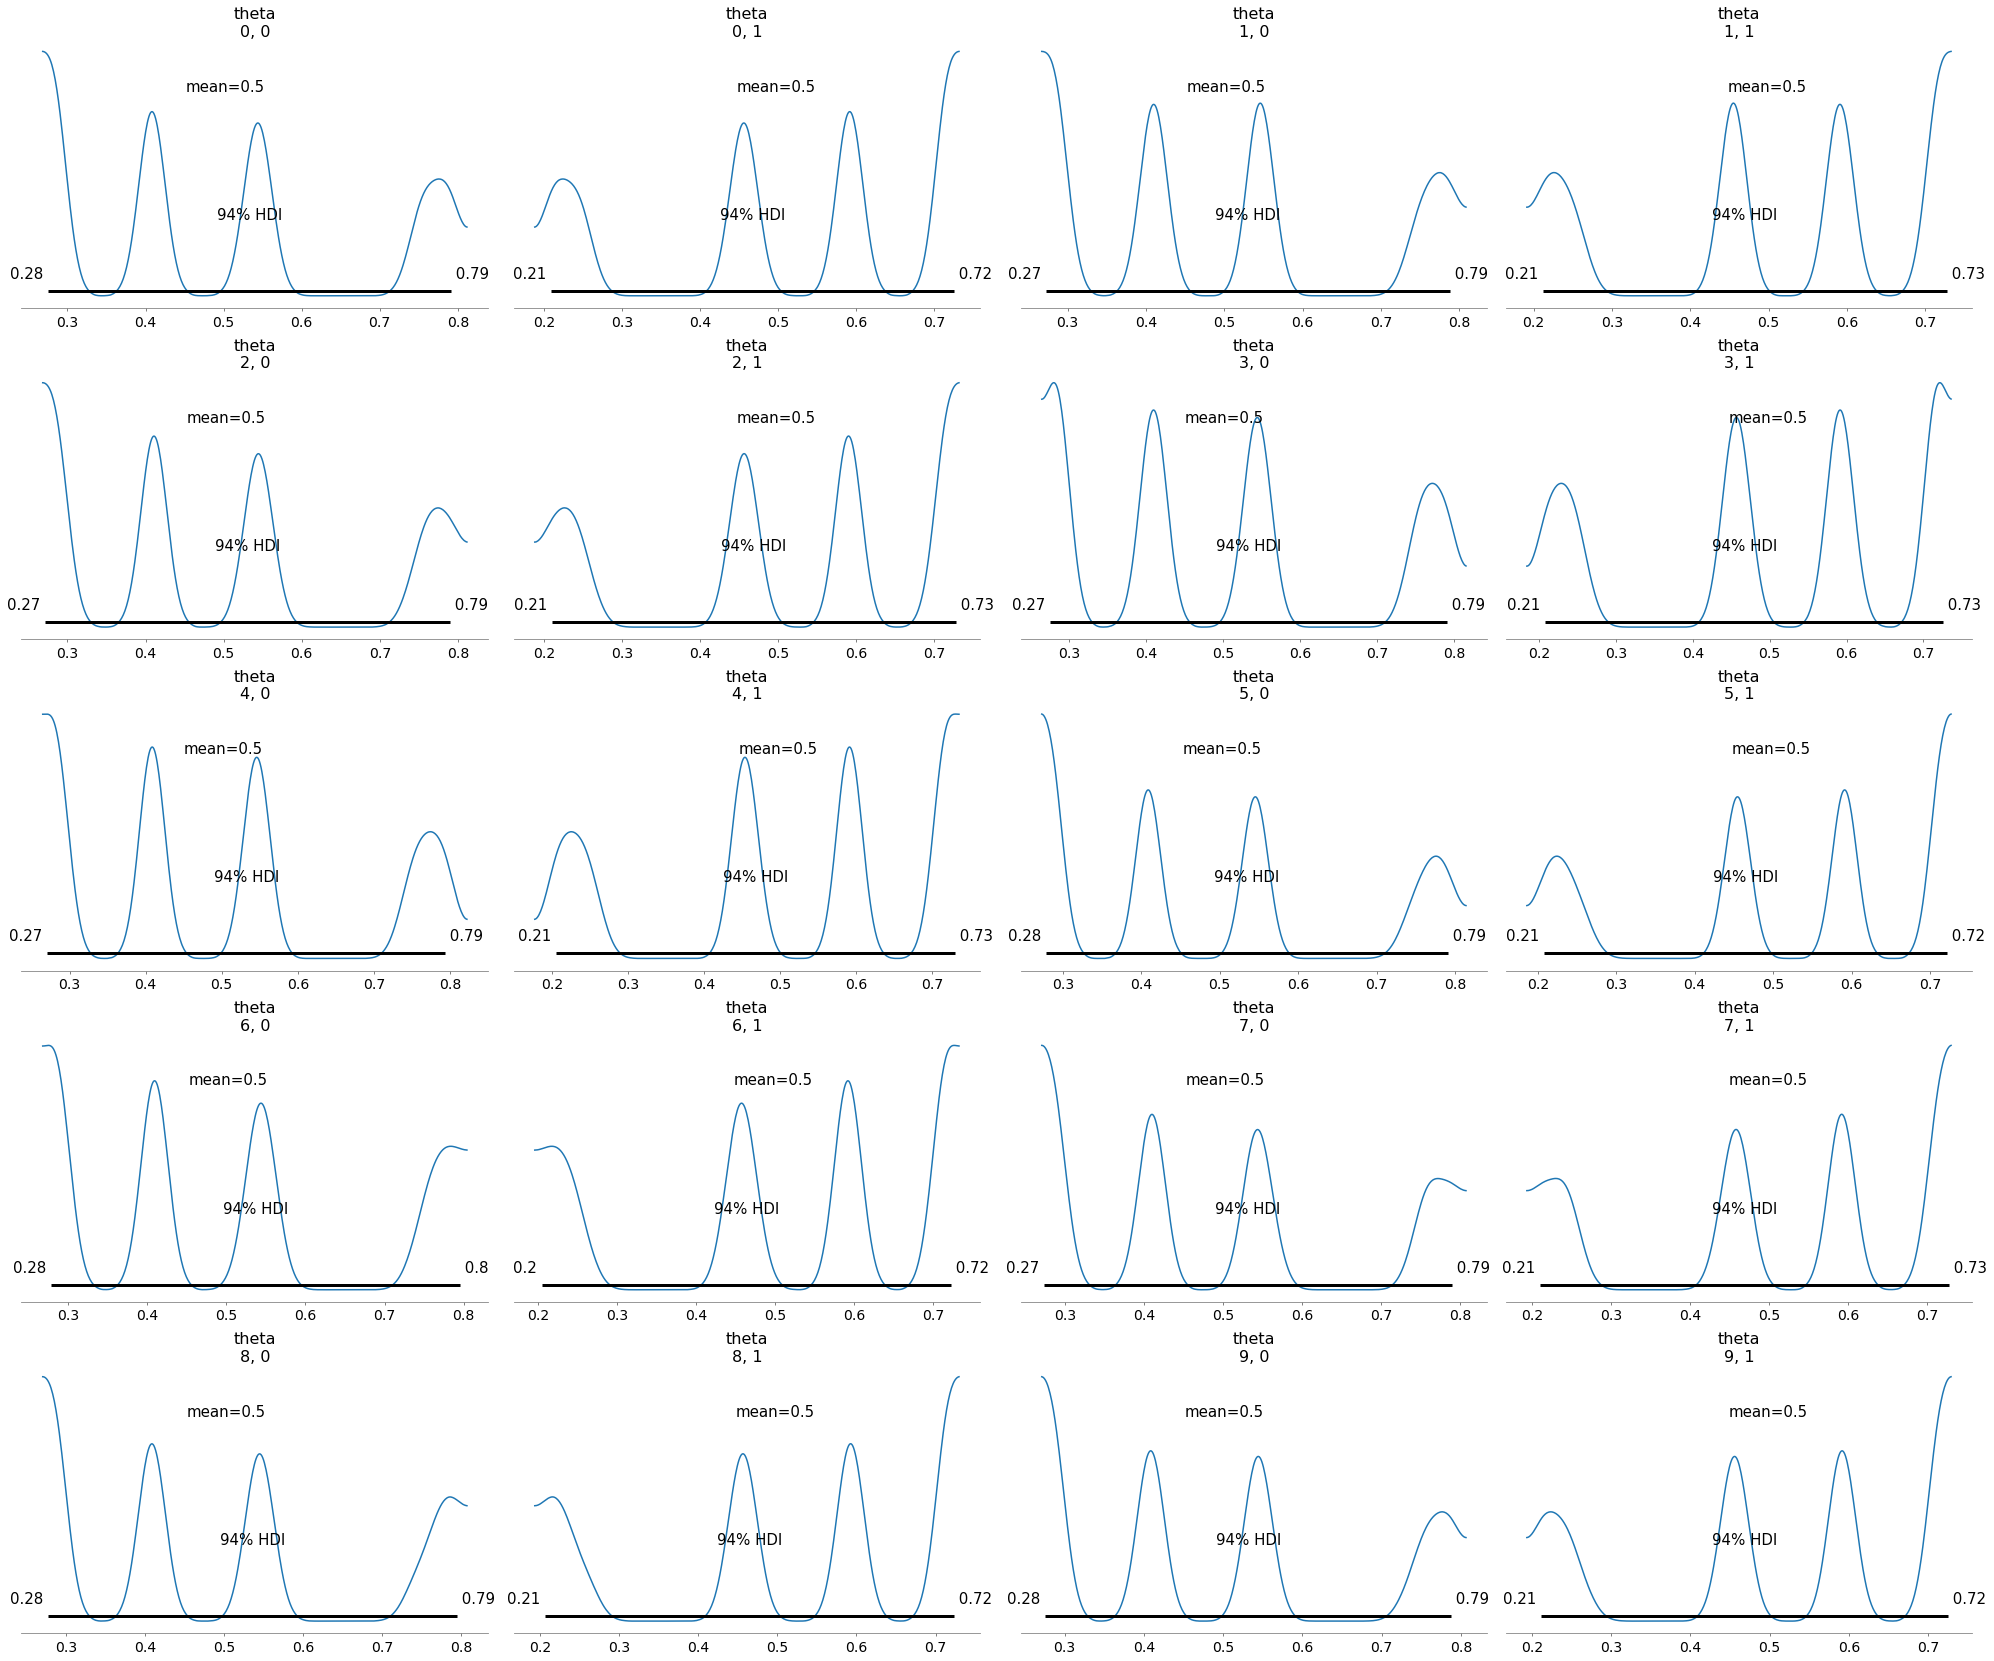

In [18]:
#pm.plot_trace(collapsed_trace);
#az.plot_forest(collapsed_trace, r_hat=True);
az.plot_posterior(collapsed_trace, var_names=['theta']);

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


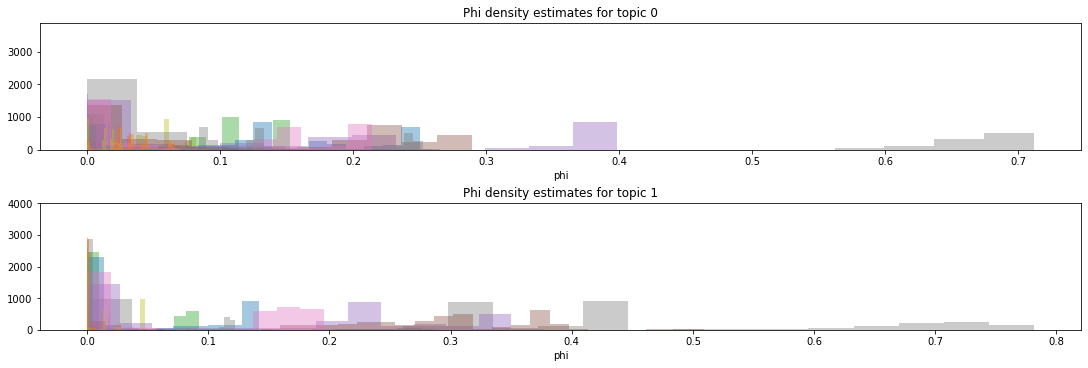

In [19]:
plt.figure(figsize=(15,5), constrained_layout = True)
for j in range(J):
    plt.subplot(J,1,j+1)
    for c in range(C):
        sns.distplot(collapsed_trace.posterior['phi'][:, :, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')

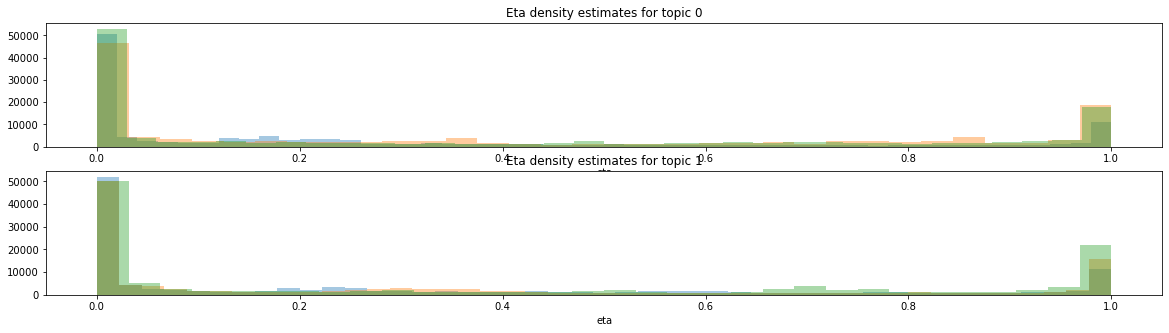

In [20]:
plt.figure(figsize=(20,5))
for k in range(K):
    plt.subplot(K,1,k+1)
    for m in range(M):
        sns.distplot(collapsed_trace.posterior['eta'][:, :, :, k, m], kde=False, hist=True)
    plt.title(f'Eta density estimates for topic {k}')

In [21]:
with collapsed_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))


[0.83255311 0.56306917]


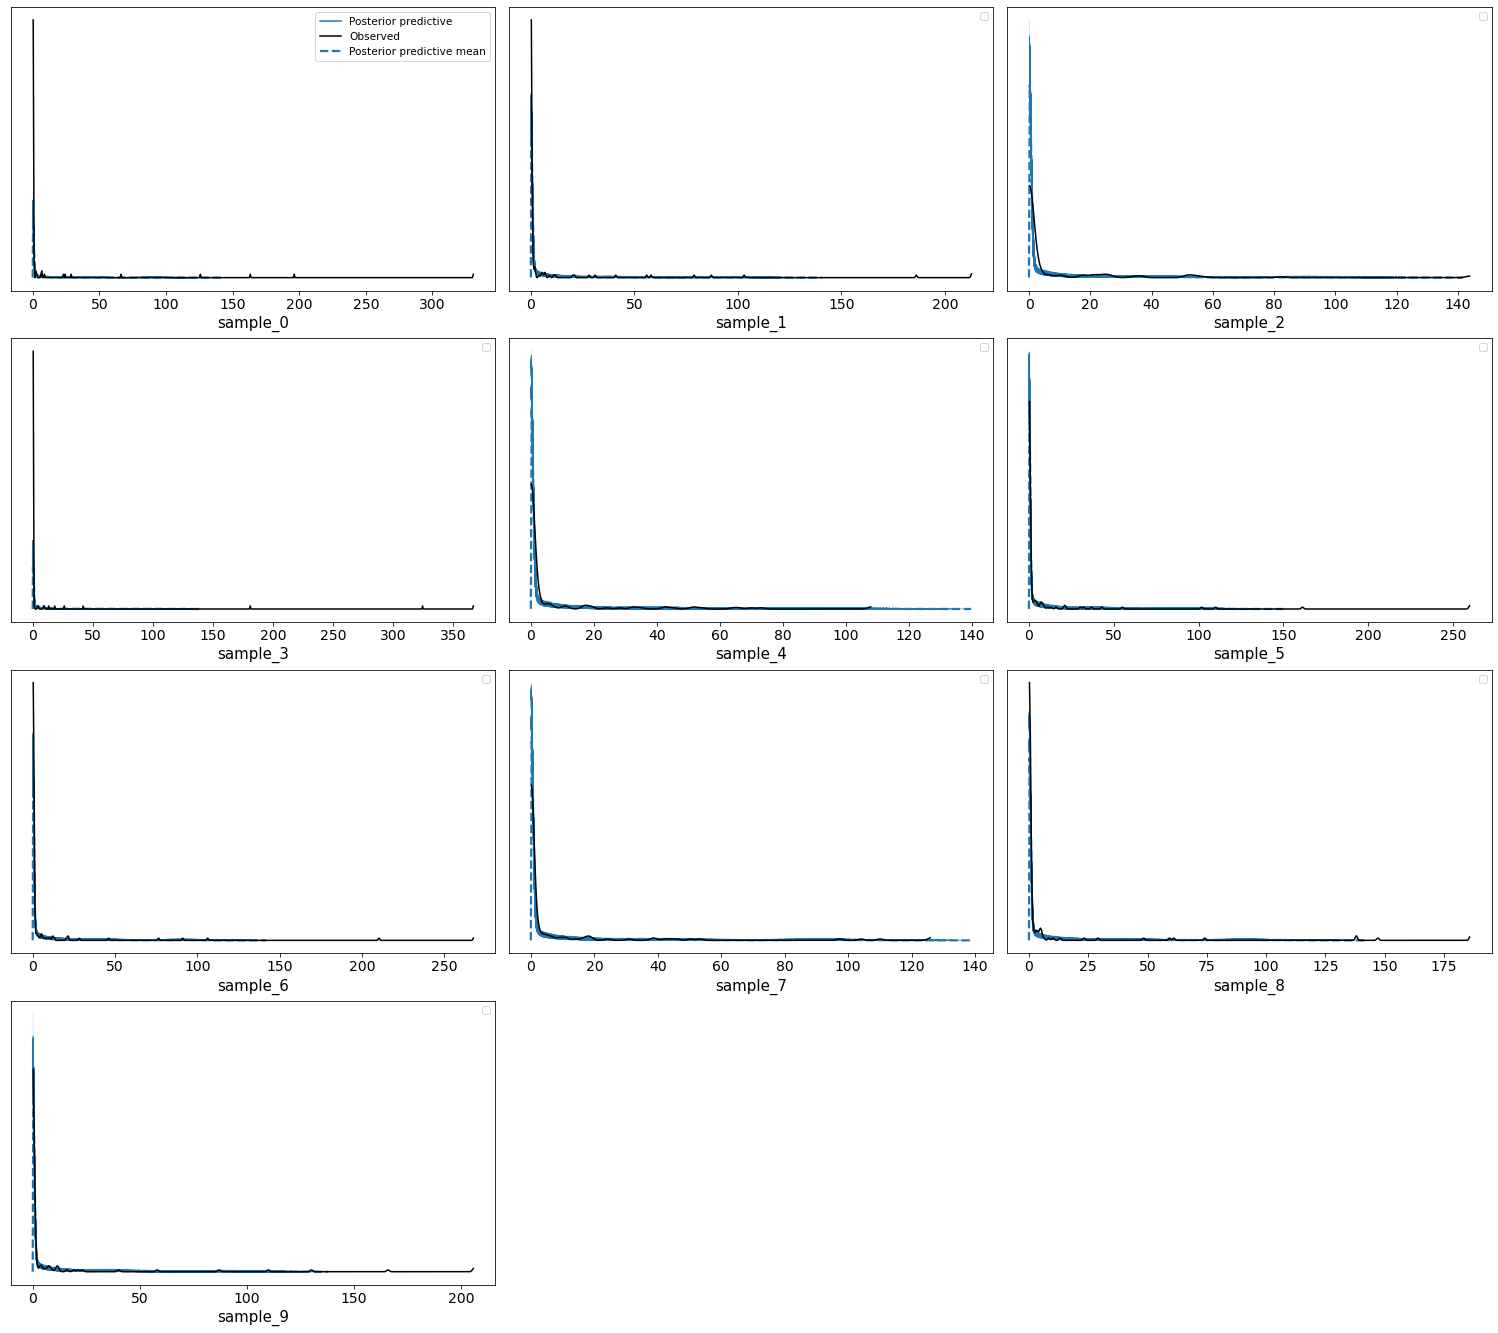

In [22]:
with collapsed_model:
    ppc = pm.sample_posterior_predictive(collapsed_trace, random_seed=5)
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=collapsed_model));

Fit the model with ADVI

In [23]:
with collapsed_model:
    advi_trace = pm.ADVI()
    advi_trace.fit()

Finished [100%]: Average Loss = 87,618


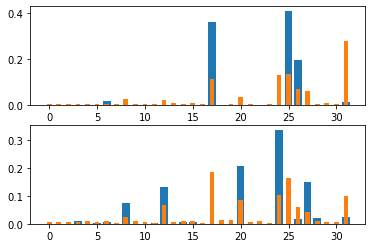

In [24]:
with collapsed_model:
    
    phi_hat=advi_trace.approx.sample_node(phi).eval();

    for j in range(J):
        plt.subplot(J,1,j+1)
        plt.bar(range(C), phi_gen[j])
        plt.bar(range(C), phi_hat[j], width=0.5) 

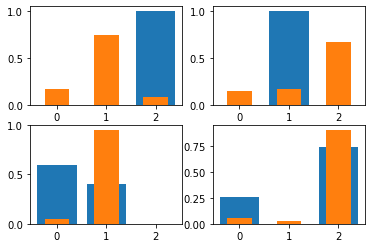

In [25]:
with collapsed_model:
    
    eta_hat=advi_trace.approx.sample_node(eta).eval();
    
    i=-1
    for k in range(K):
        i+=2
        plt.subplot(K,2,i)
        plt.bar(range(M), eta_gen[0,k])
        plt.bar(range(M), eta_hat[0,k], width=0.5)
        plt.subplot(K,2,i+1)
        plt.bar(range(M), eta_gen[16,k])
        plt.bar(range(M), eta_hat[16,k], width=0.5) 

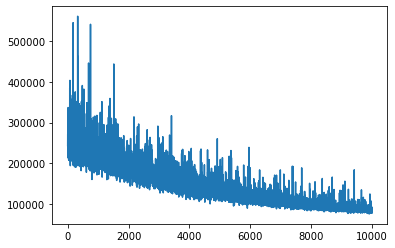

In [26]:
plt.plot(advi_trace.hist);

Finished [100%]: Average Loss = 62,615


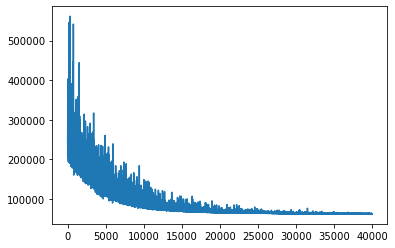

In [27]:
advi_trace.refine(30000)
plt.plot(advi_trace.hist);

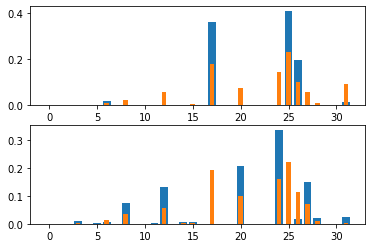

In [28]:
with collapsed_model:
    
    phi_hat=advi_trace.approx.sample_node(phi).eval();

    for j in range(J):
        plt.subplot(J,1,j+1)
        plt.bar(range(C), phi_gen[j])
        plt.bar(range(C), phi_hat[j], width=0.5) 

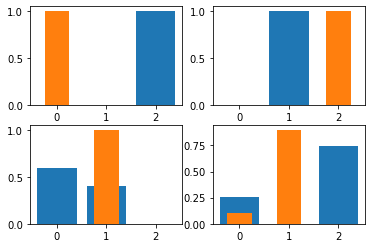

In [29]:
with collapsed_model:
    
    eta_hat=advi_trace.approx.sample_node(eta).eval();
    
    i=-1
    for k in range(K):
        i+=2
        plt.subplot(K,2,i)
        plt.bar(range(M), eta_gen[0,k])
        plt.bar(range(M), eta_hat[0,k], width=0.5)
        plt.subplot(K,2,i+1)
        plt.bar(range(M), eta_gen[16,k])
        plt.bar(range(M), eta_hat[16,k], width=0.5) 

compare NUTS to ADVI

In [1]:
with collapsed_model:
    ppc_nuts = pm.sample_posterior_predictive(collapsed_trace)
    ppc_advi = pm.sample_posterior_predictive(advi_trace.approx.sample(draws=4000))
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_nuts, model=collapsed_model));
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_advi, model=collapsed_model));

NameError: name 'collapsed_model' is not defined

In [ ]:
#advi_trace.approx.sample(1)["phi"]

In [ ]:
#with collapsed_model:
#    sns.kdeplot(range(96),advi_trace.approx.sample(100)["phi"][99], label="ADVI")